In [1]:
# !pip install spacy
# !pip install networkx
# !pip install tensorflow
# !pip install tensorflow-datasets

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

2022-07-31 15:42:13.573186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-31 15:42:13.573222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-31 15:42:20.496175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-31 15:42:20.496209: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 15:42:20.496234: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist


<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [3]:
#!python -m spacy download en_core_web_lg -q

In [4]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
# import pkg_resources
# pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [14]:
CORPUS_PATH = 'ClassCorpus_Final_v5_20220717.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [15]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                      \nWho ARE all these people?\n\nThat was what...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [\nWho ARE all these people?\n\nThat was wha...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waughs Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waughs Angel Has Fallen sees U.S. ...

## Tokenize Words

In [16]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waughs, angel, fallen, secret, se...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [boredom, set, long, start, angel, fallen, sta...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                      \nWho ARE all these people?\n\nThat was what...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [\nWho ARE all these people?\n\nThat was wha...   
lemmas                    [people, mutter, enter, screening, angel, fall...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waughs Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waughs Angel Has Fallen sees U.S. ...  
lemmas                    [ric, roman, waughs, angel, fallen, secret, se...

## Reassemble Leminized Words

In [18]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [19]:
corpus_df['lemmas_joined'].head()

Doc_ID
40    boredom set long start angel fallen start jour...
41    people mutter enter screening angel fallen loc...
42    ric roman waughs angel fallen secret service a...
43    certain mindless pleasure fallen movie watch g...
44    dont need olympus fallen andor london fallen u...
Name: lemmas_joined, dtype: object

In [20]:
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [boredom, set, long, start, angel, fallen, sta...   
lemmas_joined             boredom set long start angel fallen start jour...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                      \nWho ARE all these people?\n\nThat was what...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [\nWho ARE all these people?\n\nThat was wha...   
lemmas                    [people, mutter, enter, screening, angel, fall...   
lemmas_joined             people mutter enter screening angel fallen loc...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waughs Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waughs Angel Has Fallen sees U.S. ...  
lemmas                    [ric, roman, waughs, angel, fallen, secret, se...  
lemmas_joined             ric roman waughs angel fallen secret service a...

## Vocabulary Data Wrangling

In [21]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

# ignore terms that aren't within these frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 12203
Curated Vocabulary size: 2909


In [68]:
doc_term_df.head(5)

aaron  abandon  abduct  abigail  ability  able  \
Descriptor                                                                     
Action_Angel Has Fallen_N_40      0        0       0        0        0     0   
Action_Angel Has Fallen_N_41      0        0       0        0        0     0   
Action_Angel Has Fallen_N_42      0        1       0        0        0     0   
Action_Angel Has Fallen_N_43      0        0       0        0        0     0   
Action_Angel Has Fallen_N_44      0        0       0        0        0     1   

                              absence  absent  absolute  absolutely  ...  \
Descriptor                                                           ...   
Action_Angel Has Fallen_N_40        0       0         0           1  ...   
Action_Angel Has Fallen_N_41        0       0         0           0  ...   
Action_Angel Has Fallen_N_42        0       0         0           0  ...   
Action_Angel Has Fallen_N_43        0       0         0           0  ...   
Action_Angel Has Fallen_N_44        0       0         1           0  ...   

                              youd  youll  young  youre  youve  zac  zero  \
Descriptor                                                                  
Action_Angel Has Fallen_N_40     0      0      0      0      0    0     0   
Action_Angel Has Fallen_N_41     0      0      0      1      0    0     0   
Action_Angel Has Fallen_N_42     1      0      0      0      0    0     0   
Action_Angel Has Fallen_N_43     0      0      1      0      0    0     0   
Action_Angel Has Fallen_N_44     0      0      0      0      0    0     0   

                              zombie  zone  zora  
Descriptor                                        
Action_Angel Has Fallen_N_40       0     0     0  
Action_Angel Has Fallen_N_41       0     0     0  
Action_Angel Has Fallen_N_42       0     0     0  
Action_Angel Has Fallen_N_43       0     0     0  
Action_Angel Has Fallen_N_44       0     0     0  

[5 rows x 2909 columns]

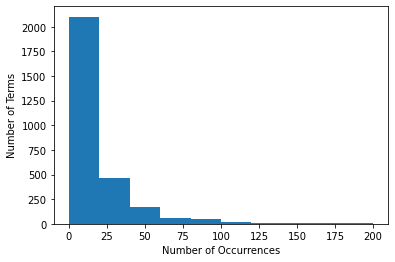

In [22]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [23]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
40    [set, long, start, angel, fallen, start, journ...
41    [people, enter, angel, fallen, local, cinema, ...
42    [ric, roman, angel, fallen, secret, service, a...
43    [certain, pleasure, fallen, watch, gerard, but...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [24]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [25]:
corpus_df.head().T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [set, long, start, angel, fallen, start, journ...   
lemmas_joined             set long start angel fallen start journey chan...   
sentences_lemmatized      [set long start angel fallen, start journey ch...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                      \nWho ARE all these people?\n\nThat was what...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [\nWho ARE all these people?\n\nThat was wha...   
lemmas                    [people, enter, angel, fallen, local, cinema, ...   
lemmas_joined             people enter angel fallen local cinema sunny l...   
sentences_lemmatized      [people enter angel fallen local cinema, sunny...   

Doc_ID                                                                   42  \
DSI_Title                                           KCM_Doc3_AngelHasFallen   
Text                      Ric Roman Waughs Angel Has Fallen sees U.S. S...   
Submission File Name                                KCM_Doc3_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_42   
Doc_ID                                                                   42   
raw_sentences             [Ric Roman Waughs Angel Has Fallen sees U.S. ...   
lemmas                    [ric, roman, angel, fallen, secret, service, a...   
lemmas_joined             ric roman angel fallen secret service agent mi...   
sentences_lemmatized      [ric roman angel fallen secret service agent m...   

Doc_ID                                                                   43  \
DSI_Title                                           KCM_Doc4_AngelHasFallen   
Text                      There is a certain mindless pleasure in the Fa...   
Submission File Name                                KCM_Doc4_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     

## Review Documents By Movie Title

In [26]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


In [27]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Minority Report'].copy()
movie_df.head(3).T

Doc_ID                                                                  115  \
DSI_Title                                           RSV_Doc6_MinorityReport   
Text                      Minority Report , directed by Steven Spielberg...   
Submission File Name                                RSV_Doc6_MinorityReport   
Student Name                                                            RSV   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                 Minority Report   
Descriptor                                     Sci-Fi_Minority Report_N_115   
Doc_ID                                                                  115   
raw_sentences             [Minority Report , directed by Steven Spielber...   
lemmas                    [minority, report, direct, steven, spielberg, ...   
lemmas_joined             minority report direct steven spielberg screen...   
sentences_lemmatized      [minority report direct steven spielberg scree...   

Doc_ID                                                                  116  \
DSI_Title                                           RSV_Doc7_MinorityReport   
Text                      Once again this year we are graced with a futu...   
Submission File Name                                RSV_Doc7_MinorityReport   
Student Name                                                            RSV   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                 Minority Report   
Descriptor                                     Sci-Fi_Minority Report_N_116   
Doc_ID                                                                  116   
raw_sentences             [Once again this year we are graced with a fut...   
lemmas                    [year, grace, futuristic, sci, fi, flick, base...   
lemmas_joined             year grace futuristic sci fi flick base short ...   
sentences_lemmatized      [year grace futuristic sci fi flick base short...   

Doc_ID                                                                  117  
DSI_Title                                           RSV_Doc8_MinorityReport  
Text                      Set in the year 2054, Steven Spielberg's Minor...  
Submission File Name                                RSV_Doc8_MinorityReport  
Student Name                                                            RSV  
Genre of Movie                                                       Sci-Fi  
Review Type (pos or neg)                                           Negative  
Movie Title                                                 Minority Report  
Descriptor                                     Sci-Fi_Minority Report_N_117  
Doc_ID                                                                  117  
raw_sentences             [Set in the year 2054, Steven Spielberg's Mino...  
lemmas                    [set, year, steven, spielberg, minority, repor...  
lemmas_joined             set year steven spielberg minority report look...  
sentences_lemmatized      [set year steven spielberg minority report loo...

In [167]:
movie_df.head(10)

DSI_Title  \
Doc_ID                             
115      RSV_Doc6_MinorityReport   
116      RSV_Doc7_MinorityReport   
117      RSV_Doc8_MinorityReport   
118      RSV_Doc9_MinorityReport   
119     RSV_Doc10_MinorityReport   
110      RSV_Doc1_MinorityReport   
111      RSV_Doc2_MinorityReport   
112      RSV_Doc3_MinorityReport   
113      RSV_Doc4_MinorityReport   
114      RSV_Doc5_MinorityReport   

                                                     Text  \
Doc_ID                                                      
115     Minority Report , directed by Steven Spielberg...   
116     Once again this year we are graced with a futu...   
117     Set in the year 2054, Steven Spielberg's Minor...   
118     In Minority Report, a futuristic thriller set ...   
119     What new hell is this? In the shallow, noisy a...   
110     Steven Spielberg’s Minority Report realizes th...   
111     In the movie it’s the future (2054) and we now...   
112     In the year 2054, at the Department of Precrim...   
113     “Minority Report” is the most un-Spielberg fil...   
114     Steven Spielberg's Minority Report is a busy f...   

            Submission File Name Student Name Genre of Movie  \
Doc_ID                                                         
115      RSV_Doc6_MinorityReport          RSV         Sci-Fi   
116      RSV_Doc7_MinorityReport          RSV         Sci-Fi   
117      RSV_Doc8_MinorityReport          RSV         Sci-Fi   
118      RSV_Doc9_MinorityReport          RSV         Sci-Fi   
119     RSV_Doc10_MinorityReport          RSV         Sci-Fi   
110      RSV_Doc1_MinorityReport          RSV         Sci-Fi   
111      RSV_Doc2_MinorityReport          RSV         Sci-Fi   
112      RSV_Doc3_MinorityReport          RSV         Sci-Fi   
113      RSV_Doc4_MinorityReport          RSV         Sci-Fi   
114      RSV_Doc5_MinorityReport          RSV         Sci-Fi   

       Review Type (pos or neg)      Movie Title  \
Doc_ID                                             
115                    Negative  Minority Report   
116                    Negative  Minority Report   
117                    Negative  Minority Report   
118                    Negative  Minority Report   
119                    Negative  Minority Report   
110                    Positive  Minority Report   
111                    Positive  Minority Report   
112                    Positive  Minority Report   
113                    Positive  Minority Report   
114                    Positive  Minority Report   

                          Descriptor  Doc_ID  \
Doc_ID                                         
115     Sci-Fi_Minority Report_N_115     115   
116     Sci-Fi_Minority Report_N_116     116   
117     Sci-Fi_Minority Report_N_117     117   
118     Sci-Fi_Minority Report_N_118     118   
119     Sci-Fi_Minority Report_N_119     119   
110     Sci-Fi_Minority Report_P_110     110   
111     Sci-Fi_Minority Report_P_111     111   
112     Sci-Fi_Minority Report_P_112     112   
113     Sci-Fi_Minority Report_P_113     113   
114     Sci-Fi_Minority Report_P_114     114   

                                            raw_sentences  \
Doc_ID                                                      
115     [Minority Report , directed by Steven Spielber...   
116     [Once again this year we are graced with a fut...   
117     [Set in the year 2054, Steven Spielberg's Mino...   
118     [In Minority Report, a futuristic thriller set...   
119     [What new hell is this?, In the shallow, noisy...   
110     [Steven Spielberg’s Minority Report realizes t...   
111     [In the movie it’s the future (2054) and we no...   
112     [In the year 2054, at the Department of Precri...   
113     [“Minority Report” is the most un-Spielberg fi...   
114     [Steven Spielberg's Minority Report is a busy ...   

                                                   lemmas  \
Doc_ID                                                      
115     [minority, report, dire

## Knowledge Graph Extraction

In [28]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'Spielberg is one of the more gifted members of a generation of studio filmmakers whose output in general has been exceedingly poor and forgettable.'

In [29]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 532/532 [00:05<00:00, 91.63it/s]


In [ ]:
entity_pairs

[['Steven screenplay', 'latest Steven Spielberg'],
 ['Washington who', 'infallibly  killings'],
 ['they', 'freezing  units'],
 ['own police force', 'trail'],
 ['event  that', 'also  marriage'],
 ['gifted studio output', 'gifted studio filmmakers'],
 ['He', 'effectively  theme'],
 ['themes', 'middle class Americans'],
 ['personal  wealth', 'American 2 society'],
 ['Minority Report', 'intriguing Philip K. elements'],
 ['expense', ''],
 ['filmmakers', 'ingenious  2054'],
 ['contemporary science imagination', 'only  people'],
 ['Minority which', 'social  creators'],
 ['crime', 'century'],
 ['', ''],
 ['', 'social  reality'],
 ['right wing crime', 'merely  consequences'],
 ['psychics', 'possible turning film'],
 ['who', 'offenses'],
 ['actual  events', 'themselves'],
 ['One', 'small  mercies'],
 ['preemptively  who', 'preemptively  everyone'],
 ['day  indeed!It', 'day  democracy'],
 ['much popcorn I', 'due  process'],
 ['Doris Kearns who', 'constitutional  Precrime'],
 ['idea', 'Rights?”’”S

### entities by document

In [168]:
def get_entities2(row):
    ner_entities = []
    # entity_id = row['Descriptor']
    # print(row.raw_sentences)
    corpus_text_sentences = row.raw_sentences
    # print(corpus_text_sentences)
    for x in tqdm(corpus_text_sentences):
        doc = nlp(x)
        # text = row['text']
        # doc = nlp(Text)
        for ent in doc.ents:
            # print(ent)
            # ner_entities.append([entity_id, ent.text, ent.label_])
            ner_entities.append(ent)
    return ner_entities

In [169]:
from collections import Counter
for index, row in movie_df.iterrows():
    print(row)
    result = get_entities2(row)
    # remove duplicates?
    # res = [*set(result)]
    # res = []
    # [res.append(x) for x in result if x not in res]
    # counts = pd.Series(result).value_counts()
    # x = Counter(result)
    # print(x.most_common())
    print(result)
    # movie_df.at[index, 'entities'] = result

DSI_Title                                             RSV_Doc6_MinorityReport
Text                        Minority Report , directed by Steven Spielberg...
Submission File Name                                  RSV_Doc6_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_115
Doc_ID                                                                    115
raw_sentences               [Minority Report , directed by Steven Spielber...
lemmas                      [minority, report, direct, steven, spielberg, ...
lemmas_joined               minority report direct steven spielberg screen...
sentences_lemmatized        [minority report direct steven spiel

100%|██████████| 88/88 [00:00<00:00, 88.68it/s]


[Steven Spielberg, Scott Frank, Jon Cohen, Philip K. DickMinority Report, Steven Spielberg, Washington DC, John Anderton, Tom Cruise, Anderton, some years, Spielberg, one, Americans, thirty tumultuous years, Spielberg, $2 billion, American, 1956, Philip K. Dick, 2054, Minority Report, American, half a century, Spielberg, The Pre-Crime Unit, Anderton, One, Steven Spielberg, Spielberg, first, Time, Doris Kearns Goodwin, Precrime, Spielberg, Goodwin, David Edelstein, Slate, Spielberg, Spielberg, Schindler, Minority Report, American, Good afternoon, Yakamoto, three, Pamela Parker, Aquafina, Guinness, a bad day, one, Tom Cruise, American Express, Spielberg, Lexus, Reebok, Nokia, Gap, Guinness, American Express, Bulgari, Pepsi-Cola’s, Aquafina, Lexus, $5 million, one, Minority Report, 62,000, Lexus, SC 430, Spielberg, Lexus, Spielberg, Lexus, Mike] Wells, Lexus, 50 years, Lexus, Spielberg, Phonemaker Nokia, an estimated $2 million, Cruise, Nokia, 599, May, 2002, Nokia, Minority Report, Ameri

100%|██████████| 23/23 [00:00<00:00, 84.70it/s]


[this year, Philip Dick, Minority Report, the year 2054, Washington, D.C., Tom Cruise, John Anderton, Pre-Crime Division, the Justice Department, three, a few minutes to four days, two, Washington, D.C., Dick, 3054, Anderton, the Justice Department, Division, Anderton, Anderton, Pre-Cog, Steven Spielberg, Spielberg, A.I., Spielberg, Janusz Kaminski, Kaminski, Cruise, Anderton, Cruise, Anderton, Moore, Pre-Cog Agatha, Max von Sydow, Dune, Dredd, The Exorcist, Anderton, Bureau, Burgess, Anderton, Colin Farrell, FBI, Danny Witwer, Spielberg, Steve Harris, Eugene Young, The Practice, Jad, Neal McDonough, Fletcher, Spielberg, Jessica Capshaw, Evanna, A.I.: Artificial Intelligence, Dick, Spielberg, Never Never Land]
DSI_Title                                             RSV_Doc8_MinorityReport
Text                        Set in the year 2054, Steven Spielberg's Minor...
Submission File Name                                  RSV_Doc8_MinorityReport
Student Name                                  

100%|██████████| 45/45 [00:00<00:00, 96.83it/s]


[the year 2054, Steven Spielberg's, Minority Report, Spielberg, A.I., Tom Cruise, John Anderton, the Justice Department's, three, Anderton, Precrime, Washington, D.C., the past six years, zero, Anderton, 36 hours, Anderton, Minority Report, Spielberg, one, Anderton, Minority Report, Scott Frank, Jon Cohen, dullish 1956, Philip K. Dick, first, Spielberg, A.I., Anderton, six years ago, Anderton, Tom Cruise, Anderton, Cruise, Vanilla Sky, half, Colin Farrell, Anderton, Samantha Morton, Spielberg, Kubrick, Minority Report, A.I., Minority Report, Spielberg, one, Spielberg, E.T., Cruise]
DSI_Title                                             RSV_Doc9_MinorityReport
Text                        In Minority Report, a futuristic thriller set ...
Submission File Name                                  RSV_Doc9_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or n

100%|██████████| 23/23 [00:00<00:00, 71.00it/s]


[2054, Washington DC, Precrime, the Pre-Cogs, Precrime, John Anderton, Tom Cruise, 1956, Philip K. Dick, Minority Report, Steven Spielberg, three, Minority Report, Solaris, Danny Witwer, Colin Farrell, the Justice Department, John, the Pre-Cogs, one, John!"Cruise, John Anderton, six years ago, John, May, one, Minority Report, Cruise, 24/7]
DSI_Title                                            RSV_Doc10_MinorityReport
Text                        What new hell is this? In the shallow, noisy a...
Submission File Name                                 RSV_Doc10_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_119
Doc_ID                            

100%|██████████| 48/48 [00:00<00:00, 86.28it/s]


[two, Steven Spielbergs, One, Schindler, Ryan, 12-year-old, Indiana, Jones, Peter Pan, Jurassic Park, E.T., Minority Report, Minority Report, one, one, 2, sci-fi, Philip K. Dick, Blade Runner, Washington, D.C., 2054, Pre-Crime Unit, Max von Sydow, Tom Cruise, John Anderton, three, Leonard Bernstein, Anderton, John Ashcroft, the Justice Department, the Pre-Crime Unit, Irish, Colin Farrell, F.B.I., Anderton, Anderton, the Pre-Cogs, 36 hours, the Pre-Crime, Spielberg, two hours, Cruise, Vanilla Sky, one, Scott Frank, Jon Cohen, Spielberg, gore, one, Tom Cruise, Lasik, Samantha Morton, the Pre-Cog, Tim Blake Nelson, Lois Smith, Alex McDowell, Spielberg, Superman, The Wizard of Oz, Spielberg, Gap, Washington, D.C., Cruise, millions]
DSI_Title                                             RSV_Doc1_MinorityReport
Text                        Steven Spielberg’s Minority Report realizes th...
Submission File Name                                  RSV_Doc1_MinorityReport
Student Name                

100%|██████████| 138/138 [00:01<00:00, 92.61it/s]


[Steven Spielberg, Minority Report, Philip K. Dick’s, Spielberg, Dick, 1956, Spielberg, Dick, more than forty, Dick, Spielberg, Hitchcockian, Dick, three, Minority Report, Precrime, Washington D.C.’s, Lamar Burgess, Max Von Sydow, John Anderton, Tom Cruise, Precrime, Precogs, three, Precogs, Precrime, the District of Columbia, six years, Precrime, Precrime, Anderton, Justice Department, Danny Witwer, Colin Farrell, Precrime, Anderton, Witwer, Precogs, Anderton, Anderton, Leo Crow, Anderton, first, Alfred Hitchcock’s, 39, Saboteur, Spielberg, Hitchcockian, Anderton, Northwest, Mount Rushmore, Cary Grant, Scott Frank, Jon Coen, John Anderton, Peter Stomare, Tim Blake Nelson, Daniel London, Precogs, Lois Smith, Cruise, Anderton, Anderton, twenty, Anderton, Burgess, Leo Crow, Precrime, Anderton, carhops, Anderton, Anderton, Anderton, Witwer, Anderton, Anderton, Anderton, one, Anderton, Spielberg, Hitchcock, Northwest, Cary Grant’s, Roger O. Thornhill, Detroit, Thornhill, Hitchcock, Ernest 

100%|██████████| 26/26 [00:00<00:00, 96.05it/s]


[Washington D.C., Pre-Crime, Tom Cruise, John Anderton, one, thirty-six hours, Colin Farrell, Steven Spielberg’s, A.I., Spielberg, Spielberg, Tom Cruise, John Anderton, Tom Cruise, Cruise, Colin Farrell, Danny Witwer, two, Max Von Sydow, Tom, Hitchcockian, Spielberg, Spielberg, Spielberg]
DSI_Title                                             RSV_Doc3_MinorityReport
Text                        In the year 2054, at the Department of Precrim...
Submission File Name                                  RSV_Doc3_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_P_112
Doc_ID                                                                    112
raw_sent

100%|██████████| 21/21 [00:00<00:00, 90.96it/s]


[the year 2054, the Department of Precrime, Washington, D.C., John Anderton, Tom Cruise, Precogs, three, approximately four days, over 90%, Anderton, Precogs, 1108, a few hours or minutes, Danny Witwer, Colin Farrell, the United States, first, three, one, Precog, Samantha Morton, Agatha, The following day, Anderton, Blade Runner, three, Paul Verhoeven-styled, John Williams, Indiana, Jones, Schwarzenegger, sci-fi, Spielberg, Minority Report, Philip K. Dick, Dick]
DSI_Title                                             RSV_Doc4_MinorityReport
Text                        “Minority Report” is the most un-Spielberg fil...
Submission File Name                                  RSV_Doc4_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Min

100%|██████████| 69/69 [00:00<00:00, 90.02it/s] 


[Steven Spielberg, Spielberg, Holocaust, World War I, A.I. Artificial Intelligence, Minority Report, A.I., Philip K. Dick, John Cohen, Scott Frank, One, Tom Cruise, Spielberg, Cruise, Gap, the year 2054, neuroin, today, Aughts, 4-inch, sci-fi, every month, choose?As, Catholic, George Carlin, Catholics, 1,000, Alex, three, Wally, Samantha Morton, three, Dashiell, Arthur, three, Hineman, Lois Smith, Max von Sydow, Lamar Burgess, PreCrime, Washington D.C., Danny Witwer, Colin Farrell, American, John Anderton, Cruise, PreCrime, years earlier, Lara, Kathryn Morris, D.C., Janusz Kamiński, one, Neal McDonough, Fletch, John, one, John, Peter Stormare, years ago, Nancy, Nancy, John, Stormare, PreCrime, Cruise, the PreCrime HQ, one day, one, Tim Blake Nelson, PreCrime, Nelson, Wally, John, Burgess, PreCrime, Lara, Terry Gilliam’s, Brazil, one, Philip K. Dick’s, a few years ago, Burgess, PreCrime, Agatha, Scottish, John, Lara, Spielberg, two-plus hours]
DSI_Title                                  

100%|██████████| 51/51 [00:00<00:00, 71.53it/s]

[Steven Spielberg's, Minority Report, three, Washington DC, zero, Spielberg, Ridley Scott's, Blade Runner, Philip K Dick's, Stanley Kubrick, the day, Interior, Spielberg, Tom Cruise, the Pre-Crime Unit, passionel, Cruise, Cruise, years, Cruise, first, Spielberg, Cruise, Max von Sydow, the Justice Department, Colin Farrell, exseminarian, a few seconds, Cruise, Farrrell, Cruise, Cruise, HAL 9000's, Kubrick, 2001, Pre-Crime, Philip K Dick, Spielberg, 50 years from now, Tom, daily, Fukuyama, Alex McDowell's, Spielberg, Cruise, Cruise, Farrell, Hitchcock, Kubrick, Bergman, Samantha Morton, Cruise, the end of 2001, A Space Odyssey, Lois Smith, Cruise, Arcati, NoÎl Coward's, Spielberg, Coward, American, European, Spielberg, Kubrick]


### Create DataFrame (Source, Target, Edge)

In [31]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [32]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [33]:
kg_df.head(6).T

0                     1                2  \
source        steven screenplay        washington who             they   
target  latest steven spielberg  infallibly  killings  freezing  units   
edge                         is         eliminated in      apprehended   

                       3               4                         5  
source  own police force     event  that      gifted studio output  
target             trail  also  marriage  gifted studio filmmakers  
edge                sets        abducted                        is

In [34]:
len(corpus_text_sentences)

532

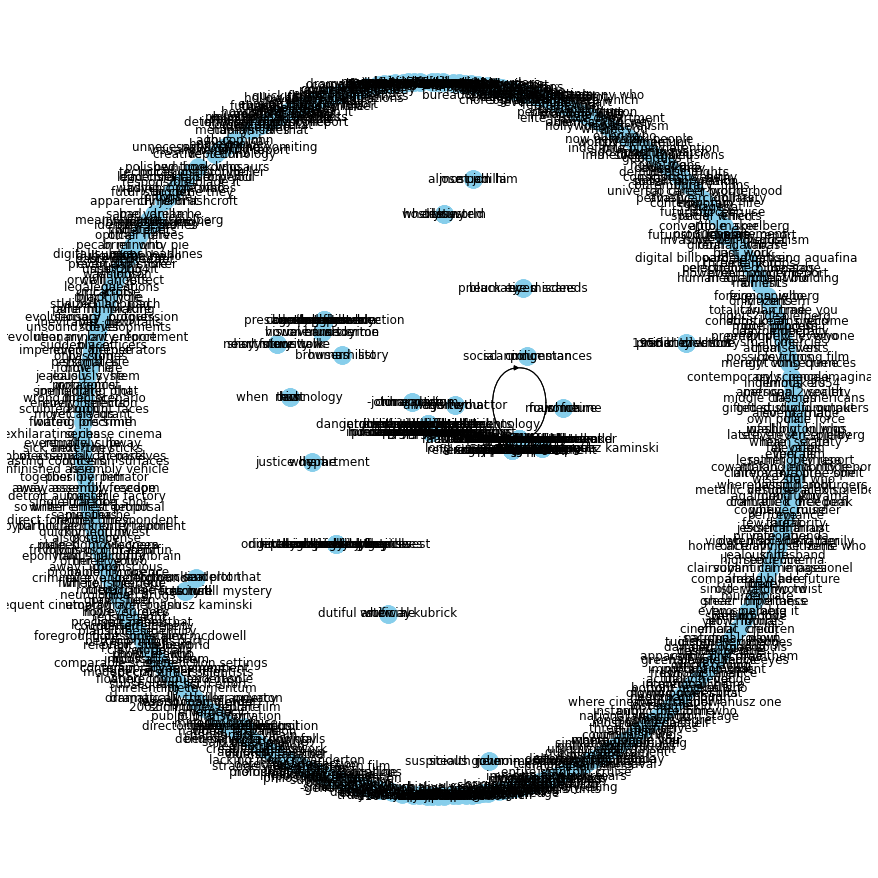

In [35]:
plot_graph(kg_df, use_circular=False)

In [69]:
get_top_sources_and_targets(kg_df)

[('it', 24),
 ('he', 16),
 ('they', 10),
 ('minority report', 9),
 ('spielberg', 9),
 ('that', 9),
 ('i', 8),
 ('anderton', 8),
 ('what', 8),
 ('who', 5)]

In [75]:
get_top_edges(kg_df, 20)

[('is', 54),
 ('has', 11),
 ('are', 10),
 ('’s', 9),
 ('have', 8),
 ('plays', 8),
 ("'s", 7),
 ('sets', 4),
 ('was', 4),
 ('uses', 4),
 ('set', 3),
 ('be', 3),
 ('takes', 3),
 ('set in', 3),
 ('goes on', 3),
 ('performs', 3),
 ('supposed', 3),
 ('made', 3),
 ('makes', 3),
 ('make', 3)]

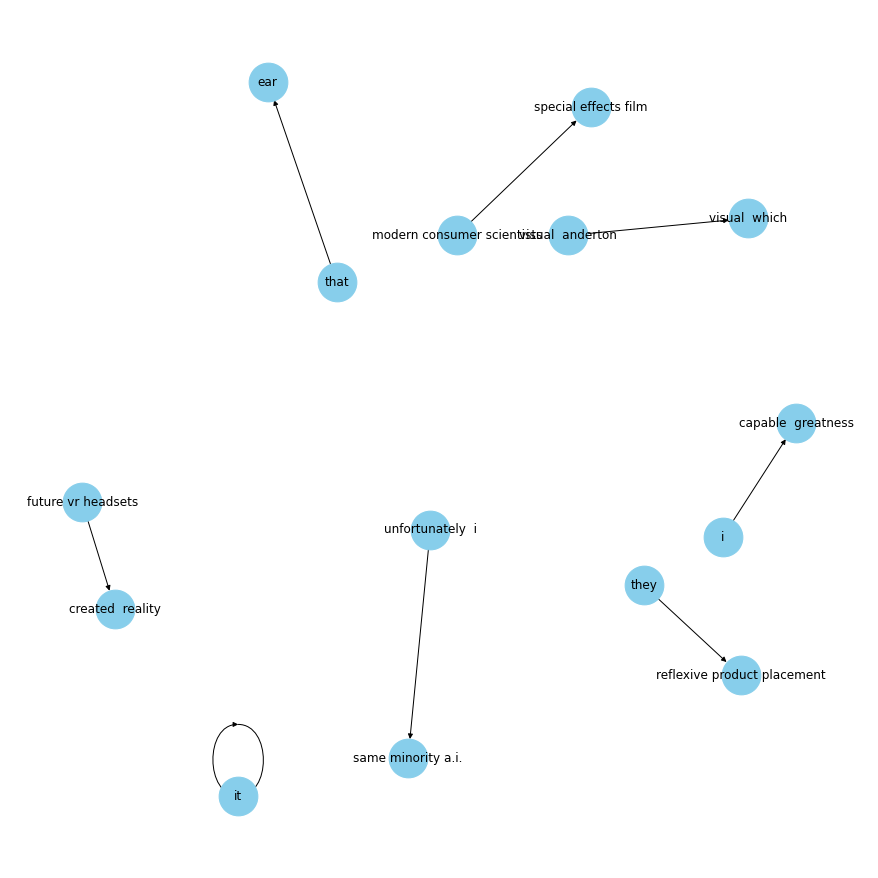

In [76]:
# input relationship in edge== to see a smaller graph
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="have"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## A plotly example

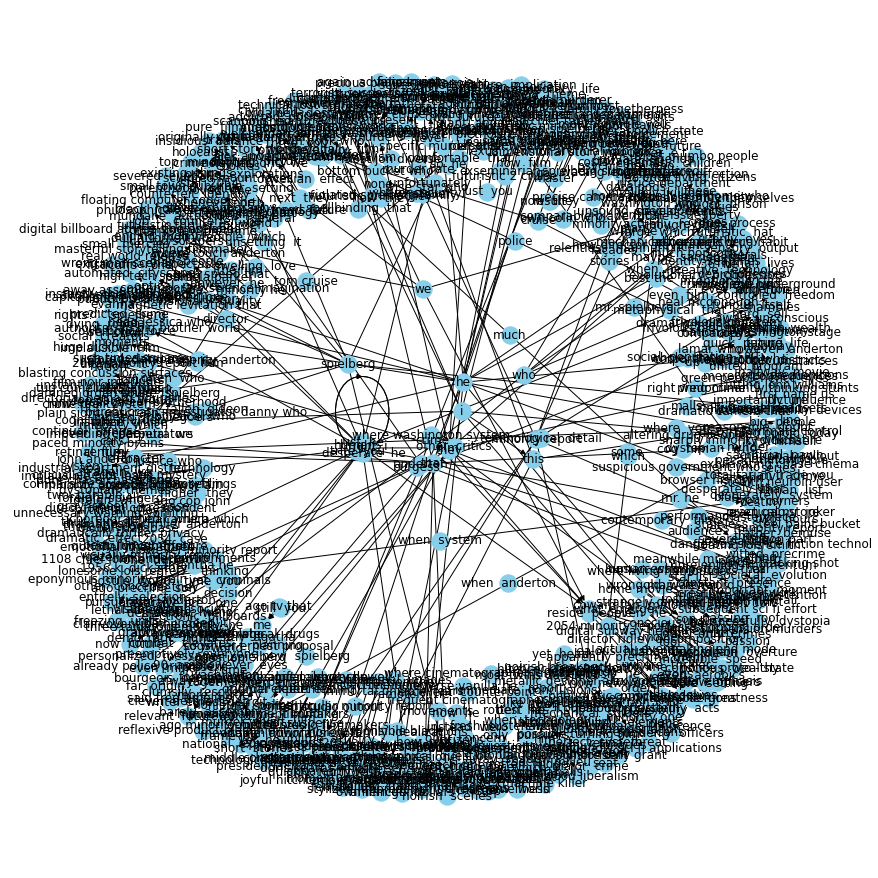

In [78]:
import plotly.graph_objects as go
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [80]:
G.nodes

NodeView(('steven screenplay', 'latest steven spielberg', 'washington who', 'infallibly  killings', 'they', 'freezing  units', 'own police force', 'trail', 'event  that', 'also  marriage', 'gifted studio output', 'gifted studio filmmakers', 'he', 'effectively  theme', 'themes', 'middle class americans', 'personal  wealth', 'american 2 society', 'minority report', 'intriguing philip k. elements', 'filmmakers', 'ingenious  2054', 'contemporary science imagination', 'only  people', 'minority which', 'social  creators', 'crime', 'century', 'right wing crime', 'merely  consequences', 'psychics', 'possible turning film', 'who', 'offenses', 'actual  events', 'themselves', 'one', 'small  mercies', 'preemptively  who', 'preemptively  everyone', 'day  indeed!it', 'day  democracy', 'much popcorn i', 'due  process', 'doris kearns who', 'constitutional  precrime', 'idea', 'rights?”’”spielberg', 'totalitarian trade you', 'civil  crime', 'right  i', 'it', 'only  concern', 'citizens', 'foreign  who', 

https://www.kaggle.com/code/anand0427/network-graph-with-at-t-data-using-plotly/notebook

In [90]:
# positions of nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

In [92]:
# Adding positions of the nodes to the graph
for n, p in pos.items():
    G.nodes[n]['pos'] = p

In [94]:
# plot with plotly
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [95]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [100]:
# !pip install jupyterlab "ipywidgets>=7.5"

     |████████████████████████████████| 8.8 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 344 kB 68.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 81.1 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 4.7 MB/s  eta 0:00:01
     |████████████████████████████████| 54 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 80 kB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 56.8 MB/s eta 0:00:01
  Created wheel for json5: filename=json5-0.9.8-py2.py3-none-any.whl size=18587 sha256=1209472ab2178b5a46a1ee6ac932dccff724a614de553335aaa1e98033029d70
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/33/13/22/d6429949983cbc014ae883a13af8b3ce949adcc4cf9196a4b9
Successfully built json5


In [106]:
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

In [107]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.offline as pyo
pyo.init_notebook_mode()
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>network connections',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# iplot(fig)
# Plot it and save as basic-line.html
pyo.plot(fig, filename = 'Test-bar.html', auto_open = True)
# plotly.plot(fig)

# Show HTML
from IPython.display import HTML
HTML(filename='Test-bar.html')

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [36]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

0  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [set, long, start, angel, fallen, start, journ...   
lemmas_joined             set long start angel fallen start journey chan...   
sentences_lemmatized      [set long start angel fallen, start journey ch...   

                                                                          1  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                      \nWho ARE all these people?\n\nThat was what...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [\nWho ARE all these people?\n\nThat was wha...   
lemmas                    [people, enter, angel, fallen, local, cinema, ...   
lemmas_joined             people enter angel fallen local cinema sunny l...   
sentences_lemmatized      [people enter angel fallen local cinema, sunny...   

                                                                          2  \
DSI_Title                                           KCM_Doc3_AngelHasFallen   
Text                      Ric Roman Waughs Angel Has Fallen sees U.S. S...   
Submission File Name                                KCM_Doc3_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_42   
Doc_ID                                                                   42   
raw_sentences             [Ric Roman Waughs Angel Has Fallen sees U.S. ...   
lemmas                    [ric, roman, angel, fallen, secret, service, a...   
lemmas_joined             ric roman angel fallen secret service agent mi...   
sentences_lemmatized      [ric roman angel fallen secret service agent m...   

                                                                          3  \
DSI_Title                                           KCM_Doc4_AngelHasFallen   
Text                      There is a certain mindless pleasure in the Fa...   
Submission File Name                                KCM_Doc4_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_43   
Doc_ID                                    

In [37]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet 

In [38]:
data = datafull[['Text','Genre of Movie']].copy()

In [39]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [40]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

## Create Datasets for Model Development

In [41]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [42]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

2022-07-31 15:45:41.478586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [43]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [44]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [46]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [47]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [48]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', '’', 'i', 'movie', 'one', 'like',
       'time', 'it', 'make', 'nt', 'get', 'character', 'even', 'but', '”',
       '“'], dtype='<U19')

In [49]:
vocab[-20:]

array(['underplays', 'underlined', 'underdeveloped', 'undercurrent',
       'undeniable', 'uncover', 'unconventional', 'unconscious',
       'uncomfortably', 'uncle', 'unbeknownst', 'unashamedly',
       'unapologetic', 'unanswered', 'unabomber', 'unabashedly',
       'twilight', 'twang', 'tutu', 'turf'], dtype='<U19')

## Example of Encoded Words

In [50]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  174,    1,  830, 2998,    1,  128,  128])

In [51]:
len(encoder.get_vocabulary())

5000

In [52]:
encoder(data['Text'][0])

<tf.Tensor: shape=(507,), dtype=int64, numpy=
array([   1,   54,   81,  112,  434,  225,  323,    6,  112, 2052,    7,
       2937,   43, 2493,   60, 2134,  215,   60,  656,    9, 2103, 2630,
       4683,    1,  218,    1,    1, 3201,    1,    6,  665,    1, 3069,
        376, 1594,    1,  634,    6,   71,   60,  835, 3789,    9,   66,
         24,    7,    1,    1, 4408,  119,   71, 1325,  119,  213,  119,
          1,   11,  597,    8,  456, 1037, 3281,  104,    1,   93, 4021,
       1667,   91,   41, 1188,  237,  434,  225,  323,  625,  532,   35,
         41, 1188,   29,  339,    7,   82, 1193,  615,   41, 1339,  262,
         84, 2470,   29, 1253,  464,  403,    1,  281,  363,   35,  283,
       1667, 1537,  160,  597,  581, 2493, 2523,  104,   56,  191,  581,
        810,  725,   88, 3001, 3251,  370,  969,   64,  466,  886, 1352,
       3329,    1,  273,  491,  283,  213,    6,    1, 1352,    1, 4622,
         34,   40, 2406,    1, 1118, 3948,  327, 1161, 2129, 1892,    6,
     

In [53]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'My hope high \xe2\x80\x9c Dirty Grandpa , \xe2\x80\x9d simply mere existence made practical sense . A movie starring Robert De Niro Zac Efron \xe2\x80\x99 sound like real movie . It sound like fake movie \xe2\x80\x99 see clip film \xe2\x80\x99 mocking stupidity Hollywood . For intent purpose , \xe2\x80\x9c Dirty Grandpa \xe2\x80\x9d exist form one fake trailer open \xe2\x80\x9c Tropic Thunder . \xe2\x80\x9d And yet , . All 102 minute . Before watching , mind raced stupid possibility . How many Viagra joke would ? Would somebody ask De Niro Viagra induced boner De Niro respond , \xe2\x80\x9c Are talking ? \xe2\x80\x9d shortly one grip run onto set give high five ? Would scene dog win farting contest fart hard launch inside bare , gaping as competitor : cameo Harvey Keitel ( , \xe2\x80\x99 implied , accidentally overdosed Viagra ) ? Unfortunately , moment \xe2\x80\x93 outside Pinterest page and/or dream board . But luckily , got equally stupid . Maybe even little . As may alre

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [54]:
num_classes=4 # updated from 5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [55]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [56]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 72s 1s/step - loss: 1.3895 - accuracy: 0.2453 - val_loss: 1.3844 - val_accuracy: 0.3333
Epoch 2/200


2022-07-31 15:46:57.943093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


53/53 [==============================] - 55s 1s/step - loss: 1.2320 - accuracy: 0.5157 - val_loss: 1.2666 - val_accuracy: 0.4444
Epoch 3/200


2022-07-31 15:47:52.980709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


53/53 [==============================] - 56s 1s/step - loss: 0.5329 - accuracy: 0.7987 - val_loss: 1.2690 - val_accuracy: 0.6667
Epoch 4/200


2022-07-31 15:48:48.538104: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


53/53 [==============================] - 55s 1s/step - loss: 0.1507 - accuracy: 0.9497 - val_loss: 0.5806 - val_accuracy: 0.7778
Epoch 5/200


2022-07-31 15:49:43.632189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


53/53 [==============================] - 55s 1s/step - loss: 0.0786 - accuracy: 0.9686 - val_loss: 1.5520 - val_accuracy: 0.5556
Epoch 6/200


2022-07-31 15:50:38.836905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


53/53 [==============================] - 55s 1s/step - loss: 0.0508 - accuracy: 0.9874 - val_loss: 1.1761 - val_accuracy: 0.7778
CPU times: user 19min 55s, sys: 57.8 s, total: 20min 53s
Wall time: 5min 48s


2022-07-31 15:51:33.871645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model Performance Test Accuracy

In [57]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 135ms/step - loss: 1.1421 - accuracy: 0.7222
Test Loss: 1.1420822143554688
Test Accuracy: 0.7222222089767456


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
1  1.232     0.516     1.267         0.444
2  0.533     0.799     1.269         0.667
3  0.151     0.950     0.581         0.778
4  0.079     0.969     1.552         0.556
5  0.051     0.987     1.176         0.778

In [60]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

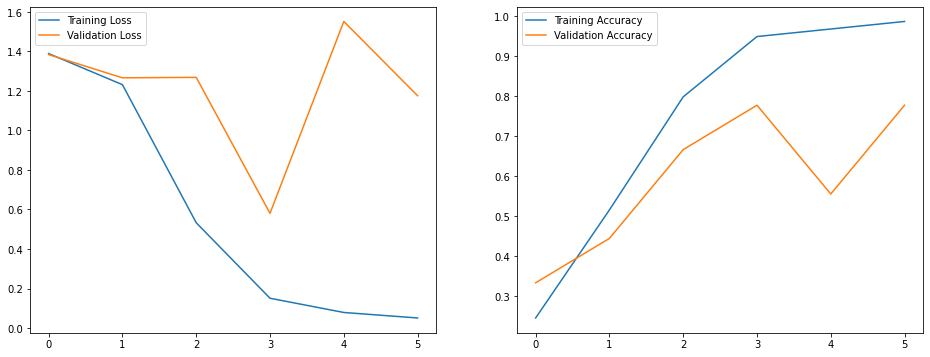

In [61]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [62]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 5s 162ms/step


In [63]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

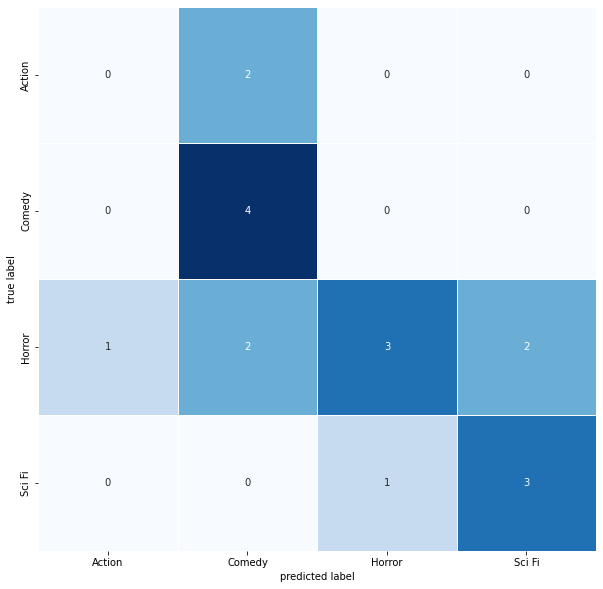

In [64]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [65]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [66]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

## RNN Model Architecture

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        